In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
os.getcwd()

'C:\\Users\\Christian\\git\\drone_steering\\models\\playground'

In [5]:
os.chdir('../..')
from app_local.module import DataEnsembler, GestureTransformer

In [6]:
de = DataEnsembler(ms_per_frame=120)

In [7]:
de = DataEnsembler(ms_per_frame=120)
de.investigate_available_datafiles(data_dir='data/gesture/')
de.load_data()
de.assemble_data(tolerance_range = 600, max_error = 700)
de.display_information()

i: 0 	shape X: (537, 17, 16) 	shape y: (537,) 	count: 61
i: 1 	shape X: (557, 17, 16) 	shape y: (557,) 	count: 116
i: 2 	shape X: (532, 17, 16) 	shape y: (532,) 	count: 67
i: 3 	shape X: (649, 17, 16) 	shape y: (649,) 	count: 85
i: 4 	shape X: (588, 17, 16) 	shape y: (588,) 	count: 60
i: 5 	shape X: (565, 17, 16) 	shape y: (565,) 	count: 86
i: 6 	shape X: (541, 17, 16) 	shape y: (541,) 	count: 0
-----------------------------------------------------------------------------
shape final X: (3969, 17, 16)
number of labeled samples: 475


In [8]:
feature_names = list(de.LabelGenerators[0].feature_names)
feat_dict = {feature:feature_names.index(feature) for feature in feature_names}

In [9]:
def plot_charts(de, file_id, tail=5, head=5, plots_per_row=30, body_part='leftWrist'):

    kx = body_part + '_x'
    ky = body_part + '_y'

    lgen = de.LabelGenerators[file_id]
    lgen.sequence_end_time[lgen.y > 0] # tbd
    np.where(lgen.y > 0)               # tbd
    y = lgen.y
    n = len(lgen.y)

    gt = GestureTransformer(byrow=True, feature_names=feature_names)
    X = gt.transform(lgen.X)
    s = lgen.X.shape[1]
    d = lgen.labeled_data
    
    dims = d[feature_names].shape
    D = d[feature_names].values.reshape(1,dims[0],dims[1])
    D = gt.transform(D).reshape(dims[0],dims[1])
    Dx = D[:,feat_dict[kx]]
    Dy = D[:,feat_dict[ky]]    
    
    for j in range(n // plots_per_row + 1):
        
        plt.figure(figsize=(2 * plots_per_row, 2))
        
        for i in range (plots_per_row):
            plt.subplot(1, plots_per_row, i + 1)
            index = j*plots_per_row + i

            # specify axes range
            axes = plt.gca()
            axes.set_xlim([-2,2])
            axes.set_ylim([-2,2])
            axes.get_yaxis().set_visible(False)
            axes.get_xaxis().set_visible(False)

            if index < n:
                if (int(y[index])>0):
                    axes.set_facecolor((0.95, 0.95, 0.95))

                # movement
                l1, u1 = max(0,index - s), index
                plt.plot(Dx[l1:u1],Dy[l1:u1],color = "xkcd:baby blue")

                # past
                l2, u2 = max(0,index - s - tail), max(0,index-s)
                plt.plot(Dx[l2:u2+1],Dy[l2:u2+1],linestyle = "--",color = "green")

                # future
                l3, u3 = index, min(index + head,dims[0])
                plt.plot(Dx[l3:u3],Dy[l3:u3],linestyle = "--",color = "red")
                
                # current frame
                plt.plot(Dx[u1-1],Dy[u1-1],color = "xkcd:baby blue",marker = "o")

                plt.title(str(index) + "/" + str(round(lgen.sequence_end_time[index]/1000,2)) + " l=" + str(int(y[index])))

        plt.show()
        plt.close()    

Available body parts:
```
leftElbow
leftHip
leftShoulder
leftWrist
rightElbow
rightHip
rightShoulder
rightWrist
```

In [10]:
de.combined_data_files_df

,filename_features,filename_labels
0,features_flip_c_01_120.csv,labels_flip_c_01.csv
1,features_flip_l_01_120.csv,labels_flip_l_01.csv
2,features_flip_p_01_120.csv,labels_flip_p_01.csv
3,features_move_c_01_120.csv,labels_move_c_01.csv
4,features_move_l_01_120.csv,labels_move_l_01.csv
5,features_move_p_01_120.csv,labels_move_p_01.csv
6,features_none_p_01_120.csv,labels_none.csv


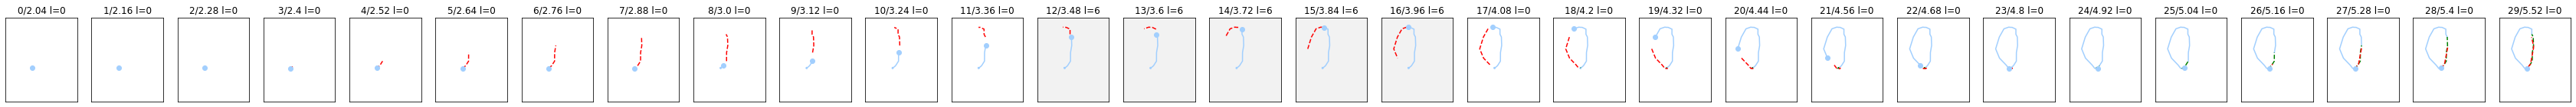

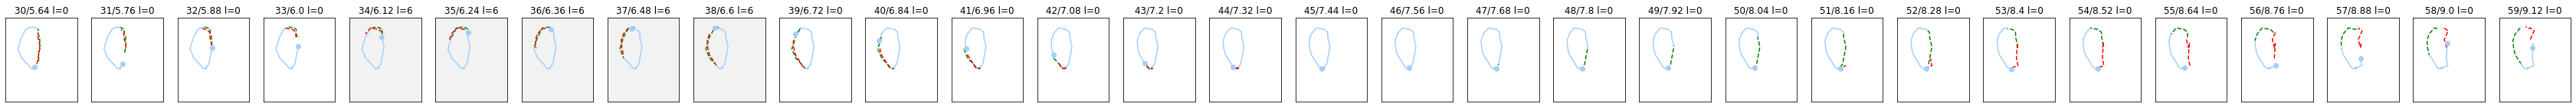

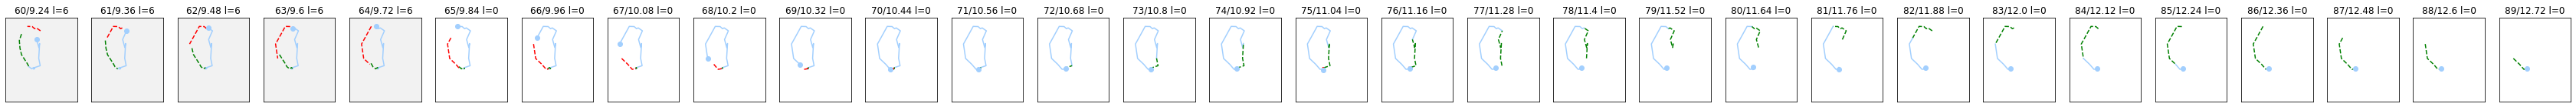

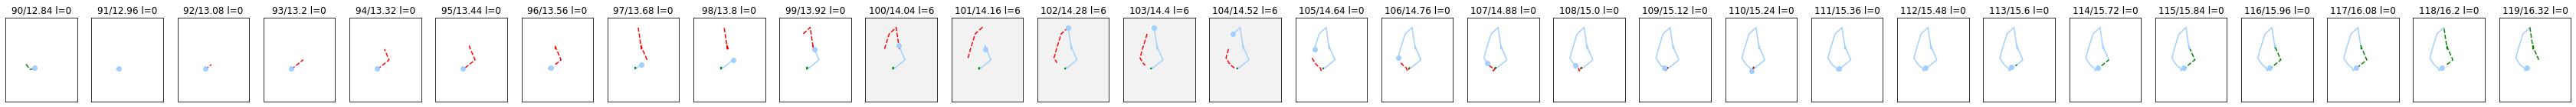

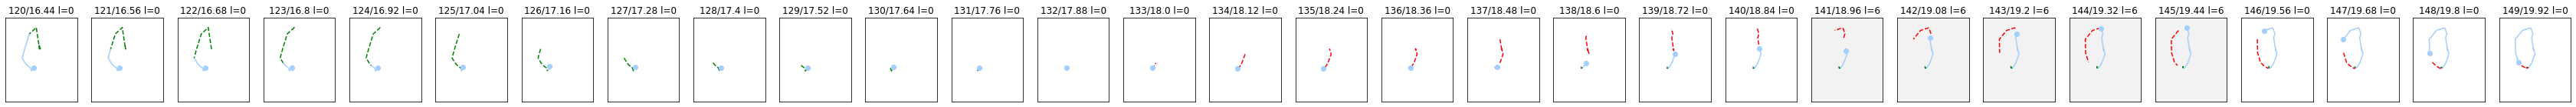

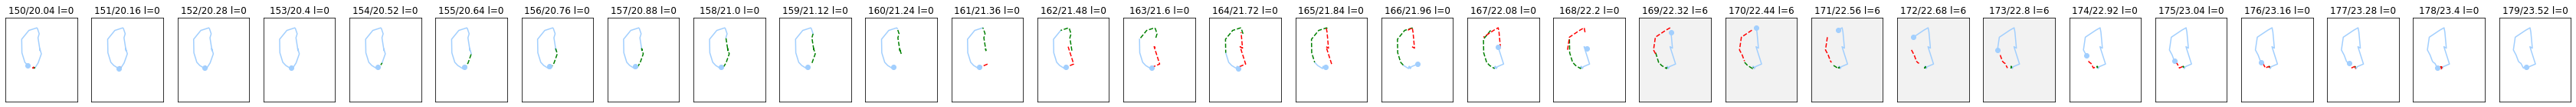

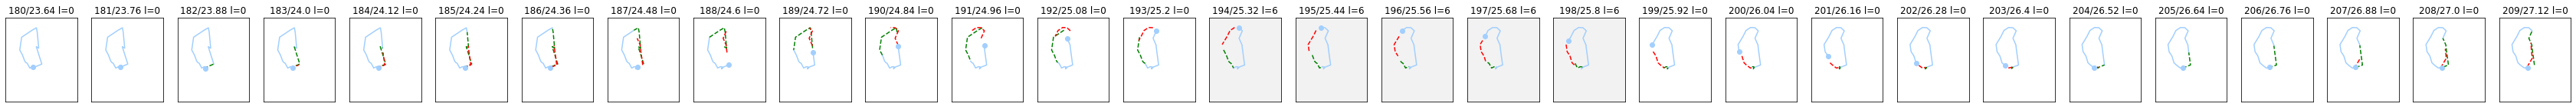

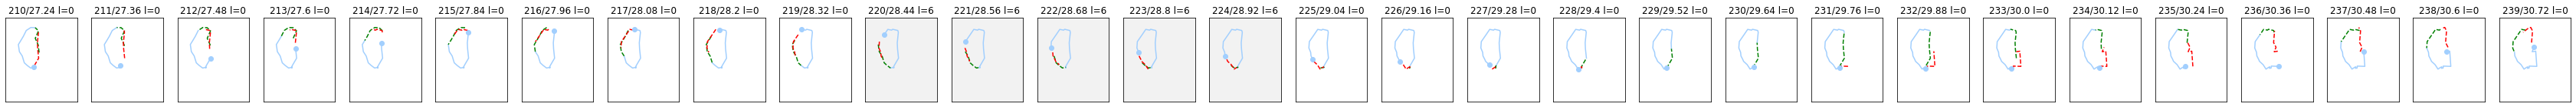

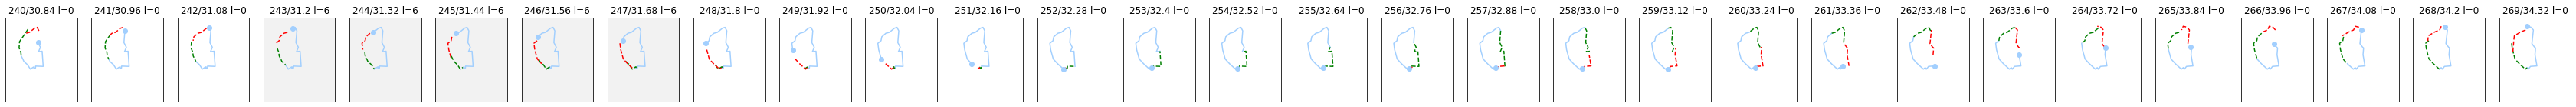

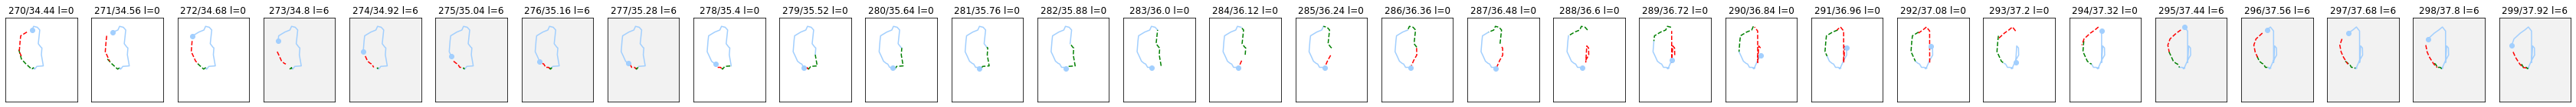

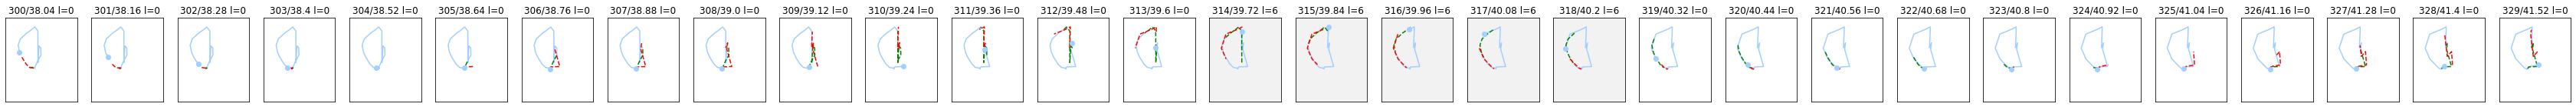

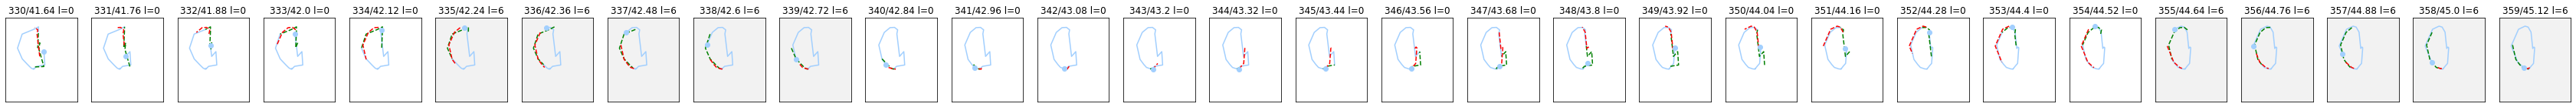

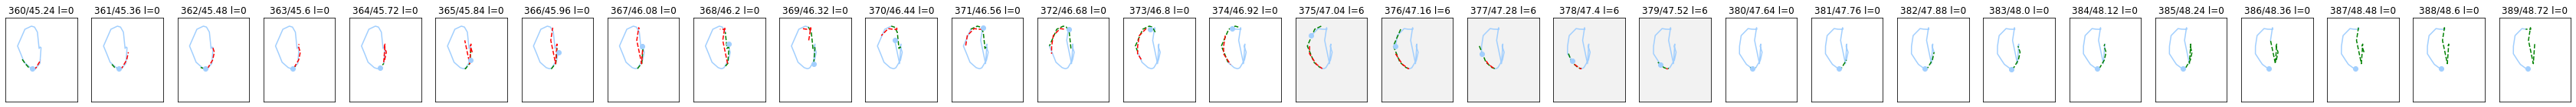

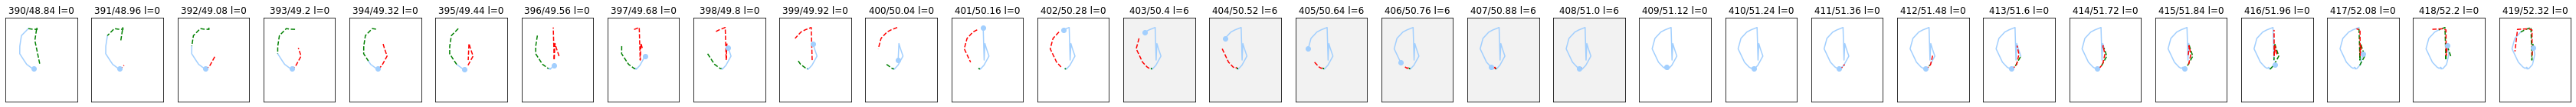

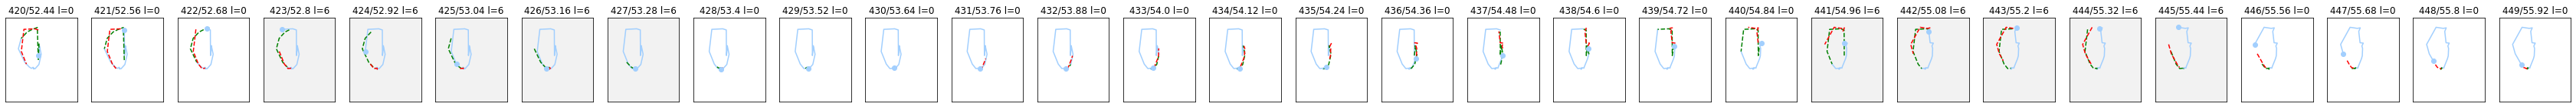

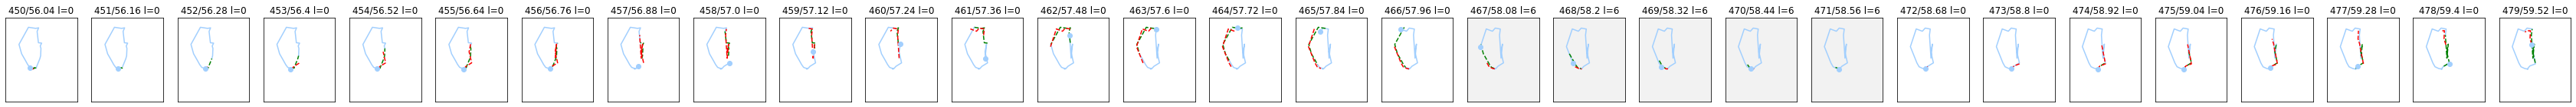

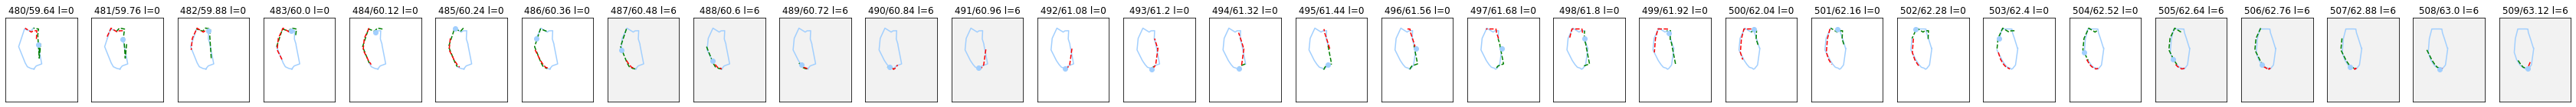

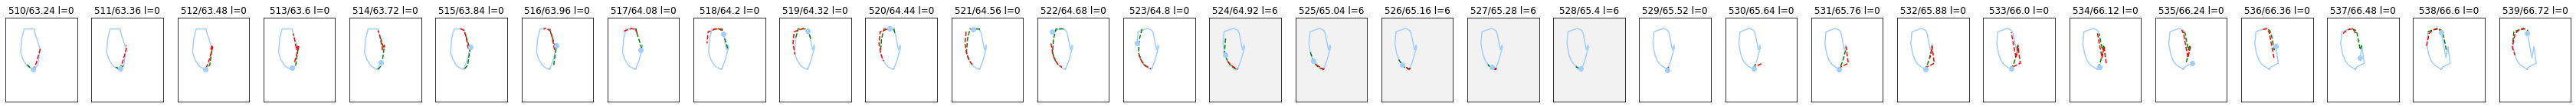

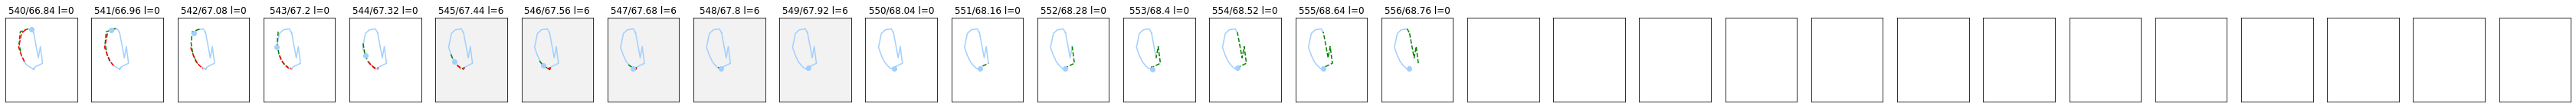

In [15]:
file_id = 1
plot_charts(de, file_id=file_id, tail=5, head=5, plots_per_row=30, body_part='leftWrist')

Display the movement endpoints (in Milliseconds) of all non-zero labeled gestures:

In [12]:
de.LabelGenerators[file_id].label_df.join(de.LabelGenerators[file_id].label_info)

,label,real_start,real_end,from,to,ignore,diff,l_slack,u_slack,tol_range_indicator
0,6,1400,3600,3400,4000,False,200,-200,400,True
1,6,4200,6300,6050,6650,False,100,-250,350,True
2,6,7400,9450,9175,9775,False,50,-275,325,True
3,6,12300,14300,14000,14600,False,0,-300,300,True
4,6,17200,19200,18900,19500,False,0,-300,300,True
5,6,20600,22550,22225,22825,False,-50,-325,275,True
6,6,23900,25700,25300,25900,False,-200,-400,200,True
7,6,26350,28600,28425,29025,False,250,-175,425,True
8,6,29150,31350,31150,31750,False,200,-200,400,True
9,6,32050,34700,34700,35350,False,650,0,650,False


Display the indices of movement ends of all non-zero labeled gestures:

In [13]:
lgen = de.LabelGenerators[file_id]
y = lgen.y

gt = GestureTransformer(byrow=True, feature_names=feature_names)
X = gt.transform(lgen.X)

gt = GestureTransformer(feature_names)
P = gt.transform(de.X)

key = 'leftWrist'
kx = key + '_x'
ky = key + '_y'

# get the label which is used in the current file
lab = y[y>0][0]

this_set = True
if not this_set: #use all the data
    movementData = P[np.isclose(de.y,lab),:,:]
else:
    movementData = X[np.isclose(y,lab),:,:]

print(movementData.shape)
movementData = movementData[:,:,[feat_dict[kx],feat_dict[ky]]]
avgMovement = movementData.mean(axis = 0)
avgMovement

(116, 17, 16)


array([[-0.73275727,  0.53105458],
       [-0.75309074,  0.3753394 ],
       [-0.75507209,  0.20475709],
       [-0.73241936,  0.04115546],
       [-0.68656892, -0.0976743 ],
       [-0.61263099, -0.19700509],
       [-0.52724567, -0.25362301],
       [-0.45074407, -0.25508141],
       [-0.38874097, -0.21578968],
       [-0.35273805, -0.15103088],
       [-0.33751025, -0.07108534],
       [-0.33650697,  0.01730053],
       [-0.34279218,  0.10622427],
       [-0.36404468,  0.19490647],
       [-0.38892962,  0.2759337 ],
       [-0.41876259,  0.32326612],
       [-0.44533995,  0.36415791]])